In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from helper import fields, interface, fields_original, from_matrix, RealWave
from fio import readin
working_dir = '/home/jiarong/research/projects/windwave/'
import matplotlib as mpl

https://aip.scitation.org/phf/authors/manuscript

In [121]:
# Helper functions

# compute mean drift
def water_profile(t,path,L0):
    # Read in the fields
    u_air, u_water, omega_air, omega_water = fields(path, t)
    # Average profile (wave coordinate!)
    u_water_1D_nointerp = np.average(u_water, axis=0)
    u_water_interp = np.zeros(u_water.shape)
    ampl = interface(path, Npoint=512, L0=1, time=t)
    zmax = L0/2 - ampl.eta_interp.max(); zmin = -L0/2 - ampl.eta_interp.min()
    zgrid = np.linspace(zmin, zmax, 512)
    from scipy.interpolate import interp1d
    for i in range(u_water.shape[0]):
        z = np.linspace(-L0/2,L0/2,512) - ampl.eta_interp[i]
        f = interp1d(z, u_water[i,:])
        ugrid = f(zgrid)
        u_water_interp[i] = ugrid
    u_water_1D = np.average(u_water_interp, axis=0)
    return u_water, u_water_interp, u_water_1D

# Compute stokes wave velocity profile
# http://basilisk.fr/src/test/stokes.h but double multiplied ak
# https://www.wikiwand.com/en/Stokes_wave#/Second-order_Stokes_wave_on_arbitrary_depth
def stokes(phase_tile,z_tile,Bo,ak,L0,CAPI=False):
    k_ = 2*np.pi; h_ = L0/2; g_ = 1; rho_ = 1
    sigma_ = 1/(Bo*k_**2)
    # Use modified gravity or not
    if not CAPI:
        g_ = 1.
    else:
        g_ = g_ + sigma_*k_**2/rho_
    alpa = 1./np.tanh(k_*h_)
    a_ = ak/k_
    sgma = ((g_*k_*np.tanh(k_*h_)*(1. + k_*k_*a_*a_*(9./8.*(alpa**2 - 1.)*(alpa**2 - 1.) + alpa**2))))**0.5
    A_ = a_*g_/sgma    
    ux = A_*np.cosh(k_*(z_tile + h_))/np.cosh(k_*h_)*k_*np.cos(phase_tile) 
    + ak*3.*A_/(8.*alpa)*(alpa**2 - 1.)*(alpa**2 - 1.)*np.cosh(2.0*k_*(z_tile + h_))*2.*k_*np.cos(2.0*phase_tile)/np.cosh(2.0*k_*h_) 
    + ak*ak*1./64.*(alpa**2 - 1.)*(alpa**2 + 3.)*(9.*alpa**2 - 13.)*np.cosh(3.*k_*(z_tile + h_))/np.cosh(3.*k_*h_)*A_*3.*k_*np.cos(3.*phase_tile)
    uy = A_*k_*np.sinh(k_*(z_tile + h_))/np.cosh(k_*h_)*np.cos(phase_tile-np.pi/2.) 
    + ak*3.*A_/(8.*alpa)*(alpa**2 - 1.)*(alpa**2 - 1.)*2.*k_*np.sinh(2.0*k_*(z_tile + h_))*np.cos(2.0*phase_tile-np.pi/2.)/np.cosh(2.0*k_*h_) 
    + ak*ak*1./64.*(alpa**2 - 1.)*(alpa**2 + 3.)*(9.*alpa**2 - 13.)*3.*k_*np.sinh(3.*k_*(z_tile + h_))/np.cosh(3.*k_*h_)*A_*np.cos(3.*phase_tile-np.pi/2.)
    return ux,uy

"""
Here the velocity partition is computed.
Input: 
eta - can come from either filtered data or original data

Hilbert transform reference
https://www.youtube.com/watch?v=VyLU8hlhI-I
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html
https://dsp.stackexchange.com/questions/46291/why-is-scipy-implementation-of-hilbert-function-different-from-matlab-implemen
"""
from scipy.signal import hilbert
def u_partition (path, t, eta, Bo=0.27, L0=1, N=512, CAPI=False): 
    u_air, u_water, omega_air, omega_water = fields(path,t)
    u,f,omega = fields_original(path,t)
    ak = np.std(eta)*2*np.pi*2**0.5
    x_eta = np.linspace(-L0/2,L0/2,np.size(eta),endpoint = False) + L0/np.size(eta)/2
    # Construct mesh (of size N)
    x = np.linspace(-L0/2,L0/2,N,endpoint = False) + L0/N/2
    z = np.linspace(-L0/2,L0/2,N,endpoint = False) + L0/N/2
    eta_interp = np.interp(x, x_eta, eta)
    # Hilbert transformation to get the phase
    analytic_signal = hilbert(eta_interp)
    phase = np.unwrap(np.angle(analytic_signal))
    z_tile, phase_tile = np.meshgrid(z,phase)
    # Linear wave velocity field; a bunch of parameters are specified
    c_ = 0.51713; k_ = 2.*np.pi
    # Using linear relation
#     ux = ak*c_*np.cos(phase_tile)*np.exp(k_*z_tile)
#     uy = ak*c_*np.cos(phase_tile-np.pi/2.)*np.exp(k_*z_tile)
    # Using Stokes wave
    ux,uy = stokes(phase_tile,z_tile,Bo,ak,L0,CAPI)
    ux_irrot = ux
    uy_irrot = uy
    # A different f field computed from interpolated eta
    for i in range(0,N):
        for j in range(0,N):
            if (z_tile[i,j]>=eta_interp[i]):
                ux_irrot[i,j] = 0.
                uy_irrot[i,j] = 0.
    ugroup = (u_water, ux_irrot,u_water-ux_irrot, uy_irrot)
    return ugroup

# Input: 
# eta_series - a real 2d numpy array with dim1 time and dim2 space
# Optional padding point number
# Output: seperated foward traveling eta1 and backward traveling eta2 as time-space 2d array 
def spectrum_filter(eta_series, N_padding = 8, WINDOW = True):
    N_time = eta_series.shape[0] # Number of time snapshots
    N_point = eta_series.shape[1] # Number of horizontal sample points    
    # Add padding so that the hanning window does not cause big changes on both ends 
    N_total = 2*N_padding + N_time
    # Use Hanning window to force ends to zero or not
    if WINDOW:
        window = np.hanning(N_total)
    else:
        window = np.ones(N_total) 
    padded_eta = np.zeros([N_total, N_point])   
    for i in range (0,N_point):
    #     zeropadded_eta[N_zero:N_time+N_zero,i] = eta_series[:,i]-np.average(eta_series[:,i])
        padded_eta[N_padding:N_time+N_padding,i] = eta_series[:,i]
        padded_eta[0:N_padding,i] = eta_series[0,i]*np.ones(N_padding)
        padded_eta[N_padding+N_time:,i] = eta_series[-1,i]*np.ones(N_padding)
        padded_eta[:,i] = padded_eta[:,i]*window
    spectrum = np.fft.fftn(padded_eta)
    # Separate the quadrants of the 2D spectrum
    spectrum1 = np.zeros(spectrum.shape); spectrum1 = spectrum1.astype(complex)
    N_half1 = np.int(N_total/2); N_half2 = np.int(N_point/2)
    spectrum1[N_half1:,:N_half2] = np.copy(spectrum[N_half1:,:N_half2])
    spectrum1[:N_half1,N_half2:] = np.copy(spectrum[:N_half1,N_half2:])
#     spectrum1[0:N_half1,:N_half2] = np.copy(spectrum[0:N_half1,:N_half2])
#     spectrum1[N_half1:,N_half2:] = np.copy(spectrum[N_half1:,N_half2:])
    # How to deal with the omega=0 part    
    spectrum2 = spectrum-spectrum1
    eta1 = np.fft.ifftn(spectrum1)
    eta2 = np.fft.ifftn(spectrum2)
    for i in range(0,N_point):
        eta1[:,i] = eta1[:,i]/(window+0.000000001)
        eta2[:,i] = eta2[:,i]/(window+0.000000001)
    return (eta1,eta2,spectrum1,spectrum2)

In [303]:
# Define the case class
import os
class Case:
    '''
    Class for each case. Initialization takes in the metadata like Bo, Re, ak etc.
    self.availt: The longest running time
    self.path: Path of the case file
    
    '''  
    def __init__(self, ustar, ak, Bo, Re, LEVEL, L0=1., g=1., k=2.*np.pi, 
                 working_dir='/home/jiarong/research/projects/windwave/', prefix='linear_m5B0', PRINTWAVE = False):
        # Register the metadata and spell the path
        self.ustar = ustar; self.ak = ak; self.Bo = Bo; self.Re = Re; self.LEVEL = LEVEL; self.L0 = L0; self.g = g; self.k = k
        self.path = working_dir + prefix + 'Ustar%gak%gBo%gRe%g.LEVEL%g' %(ustar,ak,Bo,Re,LEVEL) 
        # Run wave helper function to compute wave related info
        # Notice that this depends on the definition of the wave in the specific set of cases
        self.wave = RealWave(g = self.g, sigma = 1/(self.Bo*self.k**2), rho = 1, rho_air = 1.225*10**(-3),mu = 1./self.Re, mu_air = 1./self.Re/8.9e-4*17.4e-6)
        self.wave.k2omega(self.k)
        # Detect the available time
        for i in range (0,32*10):
            exists = os.path.exists(self.path+'/matrix/u%g.dat' %(i/32.))
            if not exists:
                self.availt = i
                break
        # Print out wave info
        if PRINTWAVE:
            print("Given k = %g (1/m), calculated omega = %g (1/s), period = %g (s), phase speed c = %g (m/s), wavelength = %g (m), Bo = %g" 
                  %(self.wave.k, self.wave.omega, 2*np.pi/self.wave.omega, self.wave.c, self.wave.wl, self.Bo))
                
    def drift_evolution(self):
        self.t = np.zeros(self.availt-1)
        self.drift_max = np.zeros(self.availt-1)
        for i in range(0, self.availt-1):
            self.t[i] = i/32.
            u_water, u_water_interp, u_water_1D = water_profile(self.t[i],self.path,self.L0)
            self.drift_max[i] = np.max(u_water_1D)
    
    # Filter out the backward traveling wave and register the filtered time-space sequence 
    # N_padding might need to be tweaked
    def spectrum_filtering(self, N_time = 96, N_padding = 9, WINDOW = True):
        N_point = 32; eta_series = []
        t = np.zeros(N_time)
        for i in range (0,N_time):
            t[i] = i/32.
            ampl = interface(case.path, Npoint=N_point, L0=case.L0, time=t[i])
            eta_series.append(ampl.eta_interp-np.average(ampl.eta_interp)) # Subtract the spatial avarage which does not change much
        # kx = np.fft.fftfreq(n=N_point,d=1/N_point); 
        # komega = np.fft.fftfreq(n=N_total,d=1/32); 
        self.eta_unfiltered = np.array(eta_series)
        eta1,eta2,spectrum1,spectrum2 = spectrum_filter(eta_series = self.eta_unfiltered, N_padding = N_padding, WINDOW = WINDOW)
        self.eta_filtered = np.copy(np.real(eta1[N_padding:N_padding+N_time,:]))
        return eta1,eta2,spectrum1,spectrum2
    
    # Compute the velocity partition at a certain time t
    # Default compute stokes without capillary modification
    # Has to come after eta_filtered has been computed or use the unfiltered version
    def call_partition(self,t_index,CAPI=False):
        N = 512 # Can change or be passed as a parameter but seems unnecessary
        ugroup_snapshot = u_partition(self.path, t_index/32, self.eta_filtered[t_index], Bo = self.Bo, L0 = self.L0, N = N, CAPI=CAPI)
        return ugroup_snapshot
    
    # Plot kinetic and potential energy - filtered eta
    def plot_energy_filtered(self, N_time, CAPI=False):
        fig = plt.figure(figsize=[3,2])
        pe_wave = np.zeros(N_time)
        ke_wave = np.zeros(N_time)
        ke_drift = np.zeros(N_time)
        N = 512 # Should match N in call_partition
        t = np.zeros(N_time)
        for i in range (0,N_time):
            t[i] = i/32
            if CAPI:
                pe_wave[i] = np.std(self.eta_filtered[i,:])**2/2*(1+1/self.Bo)*self.g
                u_group = self.call_partition(i, CAPI=True)
            else:
                pe_wave[i] = np.std(self.eta_filtered[i,:])**2/2*self.g
                u_group = self.call_partition(i, CAPI=False)
            ke_wave[i] = np.sum(u_group[1]**2 + u_group[3]**2)/N**2/2 # Take both ux and uy into wave KE
            ke_drift[i] = np.sum(u_group[2]**2)/N**2/2
        plt.plot(t,pe_wave,label='wave PE')
        plt.plot(t,ke_wave,label='wave KE')
        plt.plot(t,ke_drift,label='drift KE')
        plt.plot(t,(pe_wave+ke_wave),'.',label='wave KE + PE')
        # Direct output 
#         energy,exists = readin(self.path+'/budgetWaterwind.dat', table_delimiter = ' ', table_headers = ['t', 'ke', 'gpe'], skipn = 100)
#         if exists:
#             total = energy.ke + energy.gpe 
#         energy.insert(len(energy.columns), "total", total, True)
#         energy = energy.sort_values(by=['t'])
#         plt.plot(energy.t/(2*np.pi/self.wave.omega), energy.ke, label='KE directoutput')
#         plt.plot(energy.t/(2*np.pi/self.wave.omega), energy.gpe, label='PE directoutput')
        # plt.plot(energy1.t/T, (energy1.gpe+energy1.ke)/2., label='Total directoutput/2')
        plt.xlim([0,t[-1]]); plt.ylim([0,2e-4])
        plt.legend(loc='upper left'); plt.title(r'$u_*/c = %g, Bo = %g$' %(self.ustar,self.Bo))
        
    def plot_drift_filtered(self, ax):
        line1, = ax.plot(self.t,self.ke_drift,label='Bo=%g,Re=%g,Ustar=%g' %(case.Bo,case.Re,case.ustar))
        line2, = ax.plot(self.t,self.da*self.t+self.db,'--',label='%.4f t + %.4f' %(self.da,self.db), color=ax.lines[-1].get_color())
        return line1,line2
    
    def plot_wave_filtered(self, ax):
        line1, = ax.plot(self.t,self.energy_wave,label='Bo=%g,Re=%g,Ustar=%g' %(case.Bo,case.Re,case.ustar), linewidth = 0.5)
        line2, = ax.plot(self.t,np.exp(self.wa*self.t+self.wb),'--',label='exp(%.2f t + %.2f)' %(self.wa,self.wb), color=ax.lines[-1].get_color())
        return line1,line2
    
    def growth_rate(self,N_time,CAPI=False):
        N = 512 # Should match N in call_partition
        self.t = np.zeros(N_time)
        self.ke_drift = np.zeros(N_time)
        self.energy_wave = np.zeros(N_time)
        for i in range (0,N_time):
            self.t[i] = i/32
            if CAPI:
                u_group = self.call_partition(i, CAPI=True)
            else:
                u_group = self.call_partition(i, CAPI=False)
            self.ke_drift[i] = np.sum(u_group[2]**2)/N**2/2
            self.energy_wave[i] = np.std(self.eta_filtered[i,:])**2/2*self.g*2
        self.wa, self.wb = np.polyfit(self.t[1:], np.log(self.energy_wave[1:]), 1)
        self.da, self.db = np.polyfit(self.t[1:], self.ke_drift[1:], 1)

In [362]:
# Register the case
case_ensemble = []

for Bo,Re in zip([0.27,0.53,1.47,3.31],[2990,5000,10660,20000]):
    for ustar in [0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.4,1.6]:
        case = Case(ustar=ustar, ak=0.05, Bo=Bo, Re=Re, LEVEL=11, L0=1., g=1., k=2.*np.pi,
             working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_')
        if os.path.exists(case.path):
            case_ensemble.append(case)
            print('Bo=%g,Re=%g,Ustar=%g,c=%g,N_available=%g\npath:' %(Bo,Re,ustar,case.wave.c,case.availt)+case.path)
        case = Case(ustar=ustar, ak=0.05, Bo=Bo, Re=Re, LEVEL=11, L0=1., g=1., k=2.*np.pi,
             working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
        if os.path.exists(case.path):
            case_ensemble.append(case)
            print('Bo=%g,Re=%g,Ustar=%g,c=%g,N_available=%g\npath:' %(Bo,Re,ustar,case.wave.c,case.availt)+case.path)
            

        
# case = Case(ustar=0, ak=0.05, Bo=1.47, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
#              working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_nowind_dirac_')
# eta1,eta2,spectrum1,spectrum2 = case.spectrum_filtering(N_time = 160, N_padding = 9, WINDOW = True)
# ugroup = case.call_partition(0,CAPI=False)
# case.plot_energy_filtered(160)

Bo=0.27,Re=2990,Ustar=0.6,c=0.865227,N_available=96
path:/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_Ustar0.6ak0.05Bo0.27Re2990.LEVEL11
Bo=0.27,Re=2990,Ustar=0.8,c=0.865227,N_available=96
path:/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_Ustar0.8ak0.05Bo0.27Re2990.LEVEL11
Bo=0.27,Re=2990,Ustar=1,c=0.865227,N_available=96
path:/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_Ustar1ak0.05Bo0.27Re2990.LEVEL11
Bo=0.27,Re=2990,Ustar=1.2,c=0.865227,N_available=96
path:/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_Ustar1.2ak0.05Bo0.27Re2990.LEVEL11
Bo=0.27,Re=2990,Ustar=1.4,c=0.865227,N_available=96
path:/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_Ustar1.4ak0.05Bo0.27Re2990.LEVEL11
Bo=0.27,Re=2990,Ustar=1.6,c=0.865227,N_available=96
path:/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_Ustar1.6ak0.05Bo0.27Re2990.LEVEL11
Bo=0.53,Re=5000,Ustar=0.6,c=0.677825,N

In [329]:
# Register other comparing cases:
case_test = []
case = Case(ustar=0.8, ak=0.05, Bo=1.47, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_')
case_test.append(case)
case = Case(ustar=0.8, ak=0.05, Bo=1.47, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_test.append(case)
for case in case_test:
    if os.path.exists(case.path):
        case_ensemble.append(case)
    print('Bo=%g,Re=%g,Ustar=%g,c=%g,N_available=%g,path:' %(case.Bo,case.Re,case.ustar,case.wave.c,case.availt) + case.path)

Bo=1.47,Re=10660,Ustar=0.8,c=0.51713,N_available=160,path:/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_Ustar0.8ak0.05Bo1.47Re10660.LEVEL11
Bo=1.47,Re=10660,Ustar=0.8,c=0.51713,N_available=96,path:/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_test_Ustar0.8ak0.05Bo1.47Re10660.LEVEL11


In [364]:
# Register Bond comparing cases
case_Bo = []
case = Case(ustar=0.8, ak=0.05, Bo=1.47, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)
case = Case(ustar=1, ak=0.05, Bo=1.47, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)
case = Case(ustar=0.8, ak=0.05, Bo=3.31, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)
case = Case(ustar=1, ak=0.05, Bo=3.31, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
     working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case_Bo.append(case)
for case in case_Bo:
    if os.path.exists(case.path):
        case_ensemble.append(case)
    print('Bo=%g,Re=%g,Ustar=%g,c=%g,N_available=%g,path:' %(case.Bo,case.Re,case.ustar,case.wave.c,case.availt) + case.path)

Bo=1.47,Re=10660,Ustar=0.8,c=0.51713,N_available=96,path:/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_test_Ustar0.8ak0.05Bo1.47Re10660.LEVEL11
Bo=1.47,Re=10660,Ustar=1,c=0.51713,N_available=81,path:/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_test_Ustar1ak0.05Bo1.47Re10660.LEVEL11
Bo=3.31,Re=10660,Ustar=0.8,c=0.455234,N_available=96,path:/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_test_Ustar0.8ak0.05Bo3.31Re10660.LEVEL11
Bo=3.31,Re=10660,Ustar=1,c=0.455234,N_available=96,path:/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_test_Ustar1ak0.05Bo3.31Re10660.LEVEL11


In [365]:
for case in case_Bo:
    eta1,eta2,spectrum1,spectrum2 = case.spectrum_filtering(N_time = 96, N_padding = 9, WINDOW = True)
    case.growth_rate(81,CAPI=True)

/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_test_Ustar1ak0.05Bo1.47Re10660.LEVEL11/field/eta2.53125 cannot be read!


UnboundLocalError: local variable 'ampl' referenced before assignment

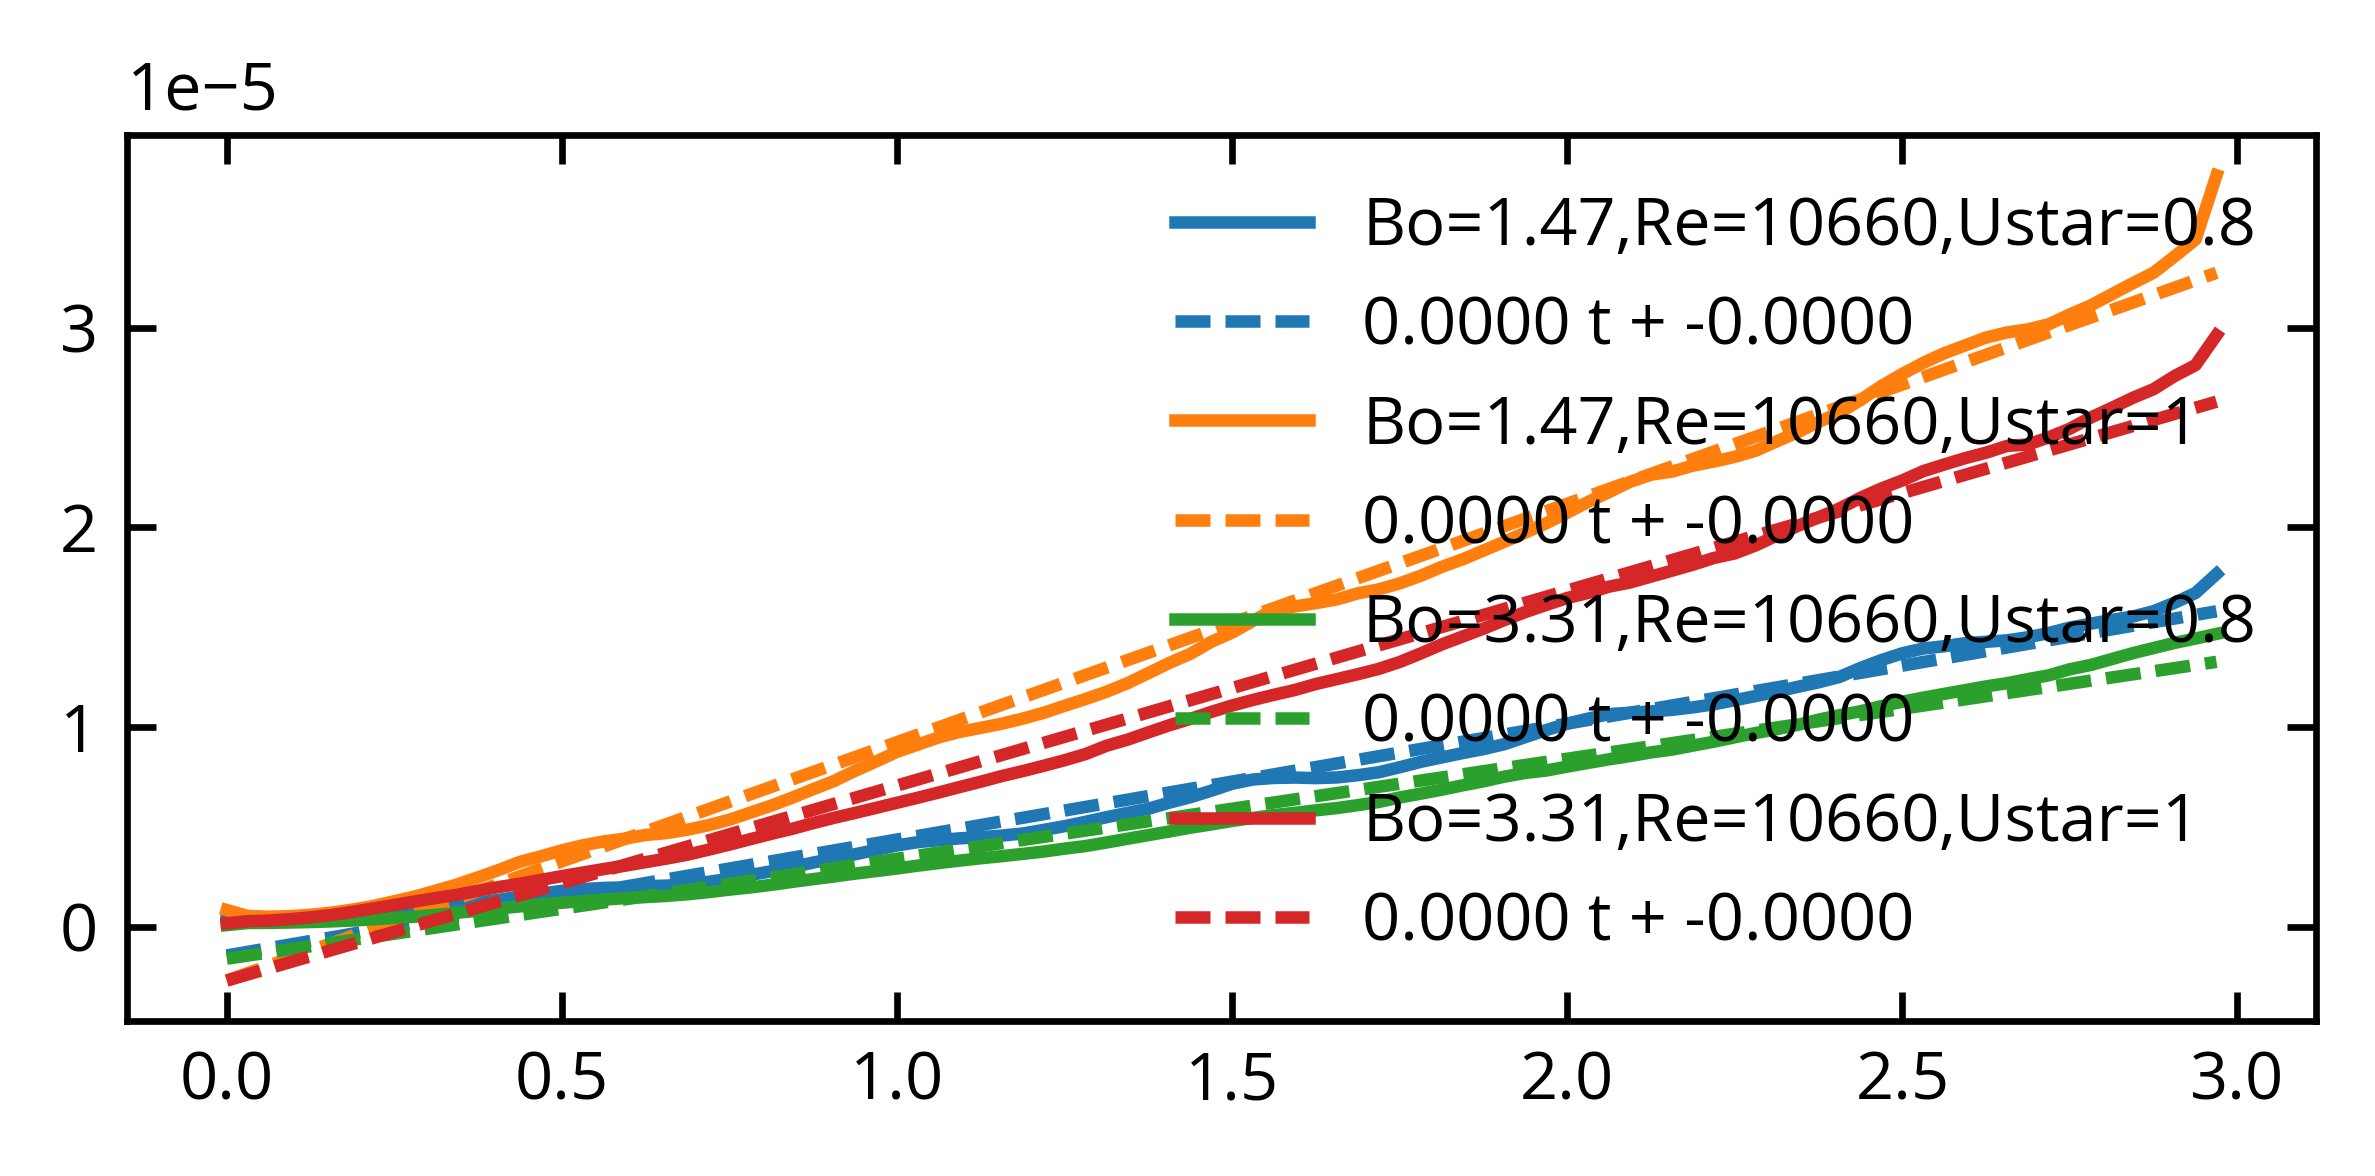

In [357]:
fig = plt.figure(figsize=[4,2]); ax = fig.gca()
for case in case_Bo:
#     eta1,eta2,spectrum1,spectrum2 = case.spectrum_filtering(N_time = 96, N_padding = 9, WINDOW = True)
#     case.growth_rate(96,CAPI=True)
    case.plot_drift_filtered(ax)
ax.legend()

In [328]:
(0.05/2/np.pi)**2/2

3.1662869888230556e-05

In [ ]:
fig = plt.figure(figsize=[4,2]); ax = fig.gca()
for case in case_ensemble:
    case.plot_wave_filtered(ax)
    print(case.da)
# ax.legend()

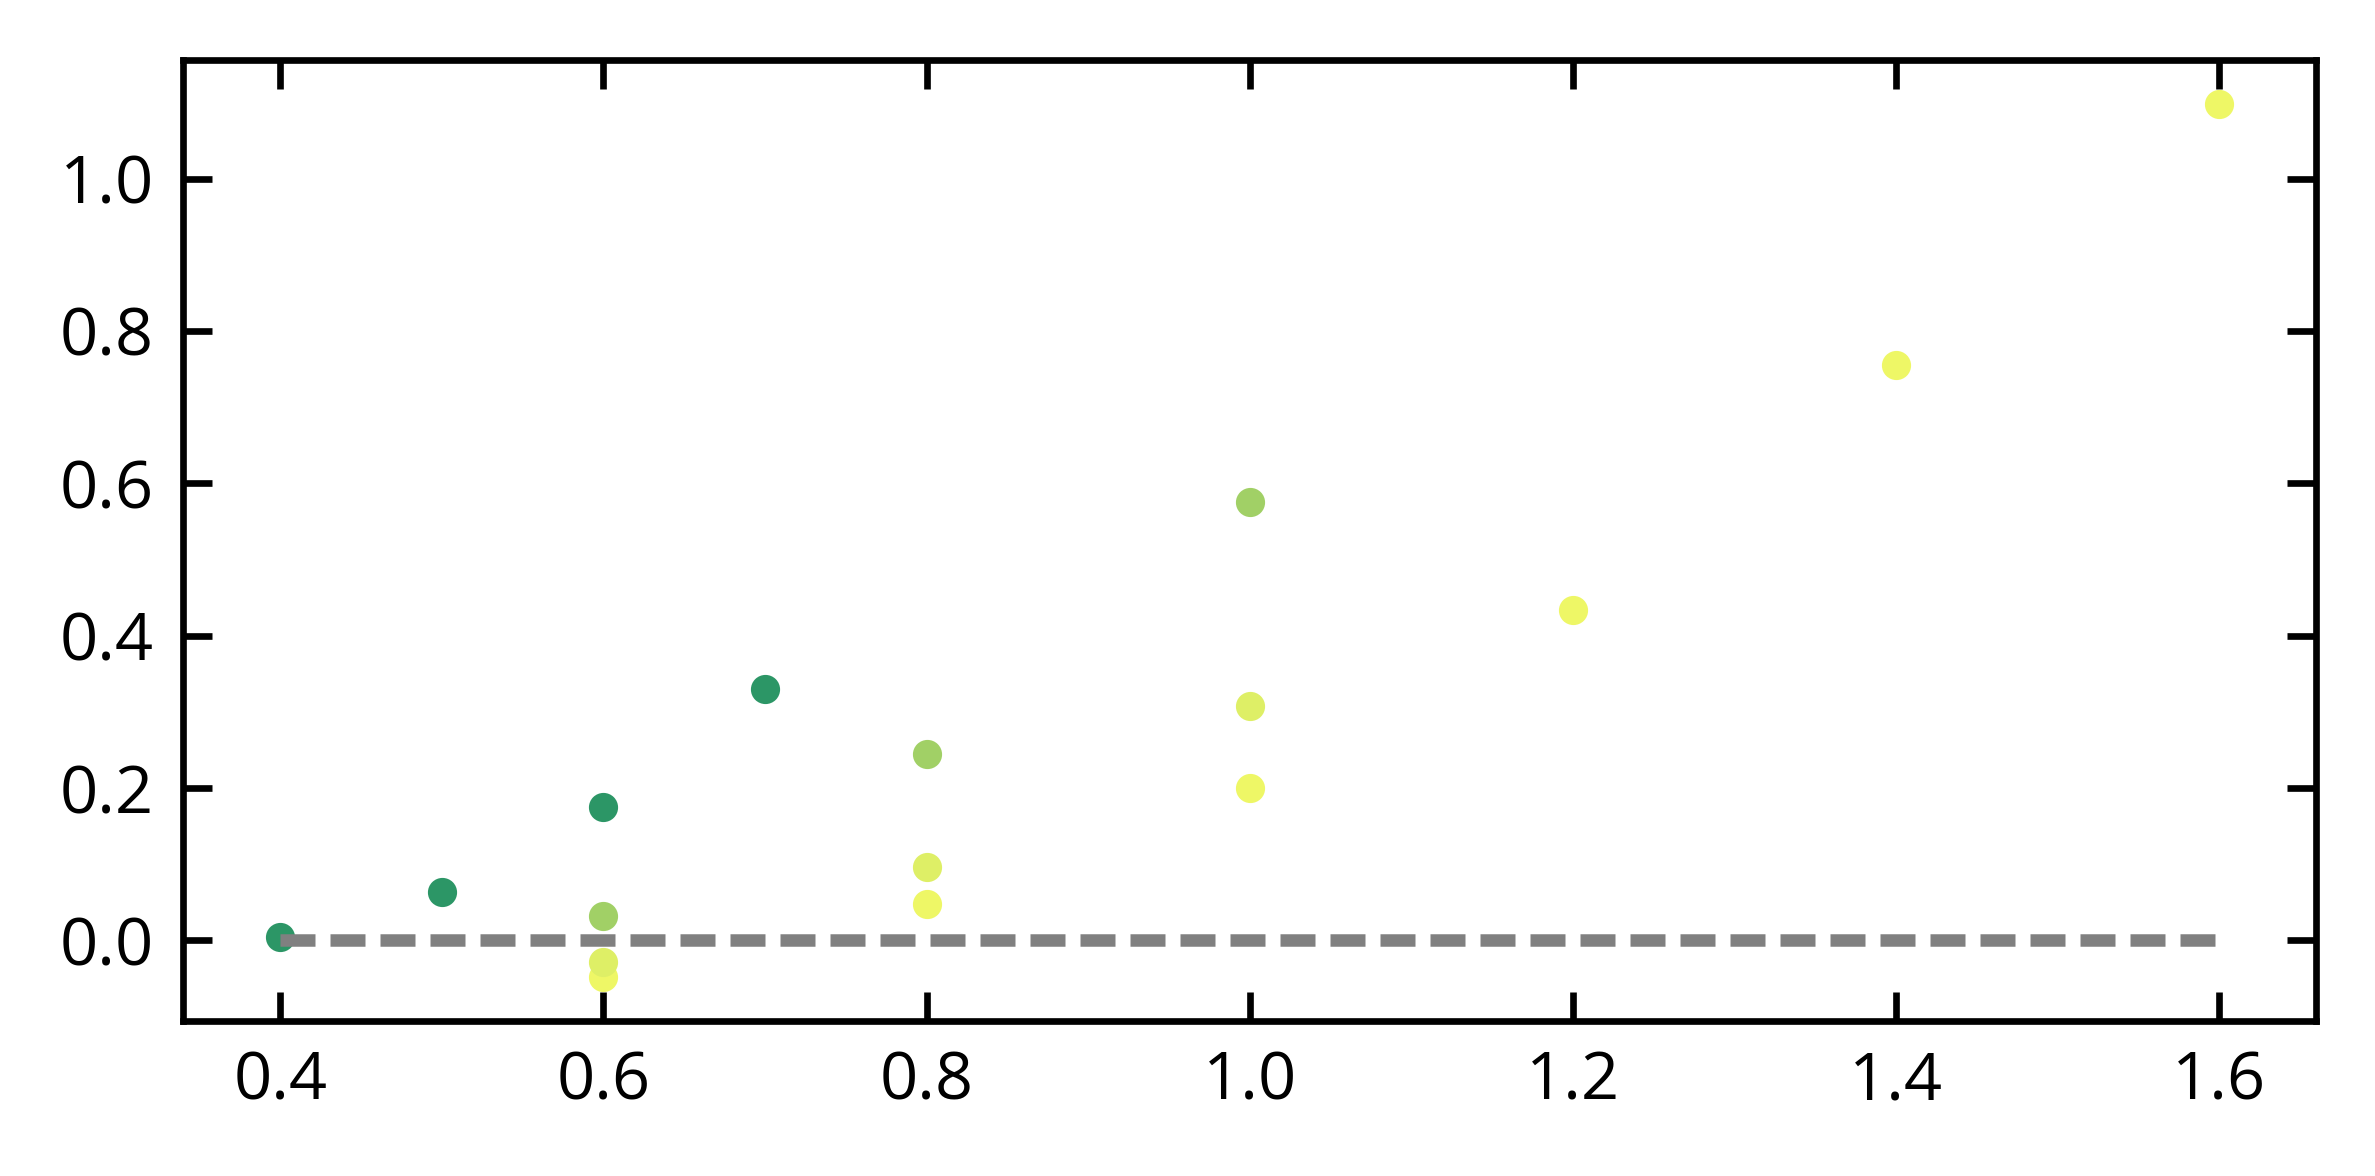

In [318]:
'''Plot the ensemble wave growth rate - exponential fit'''
fig = plt.figure(figsize=[4,2])
for case in case_ensemble:
    plt.plot(case.ustar,case.wa,'.',color=plt.cm.get_cmap('summer')(1-case.Bo/4))
ustar_ = np.arange(0.4,1.6,0.01)
plt.plot(ustar_,np.zeros(ustar_.shape),'--',color='gray')

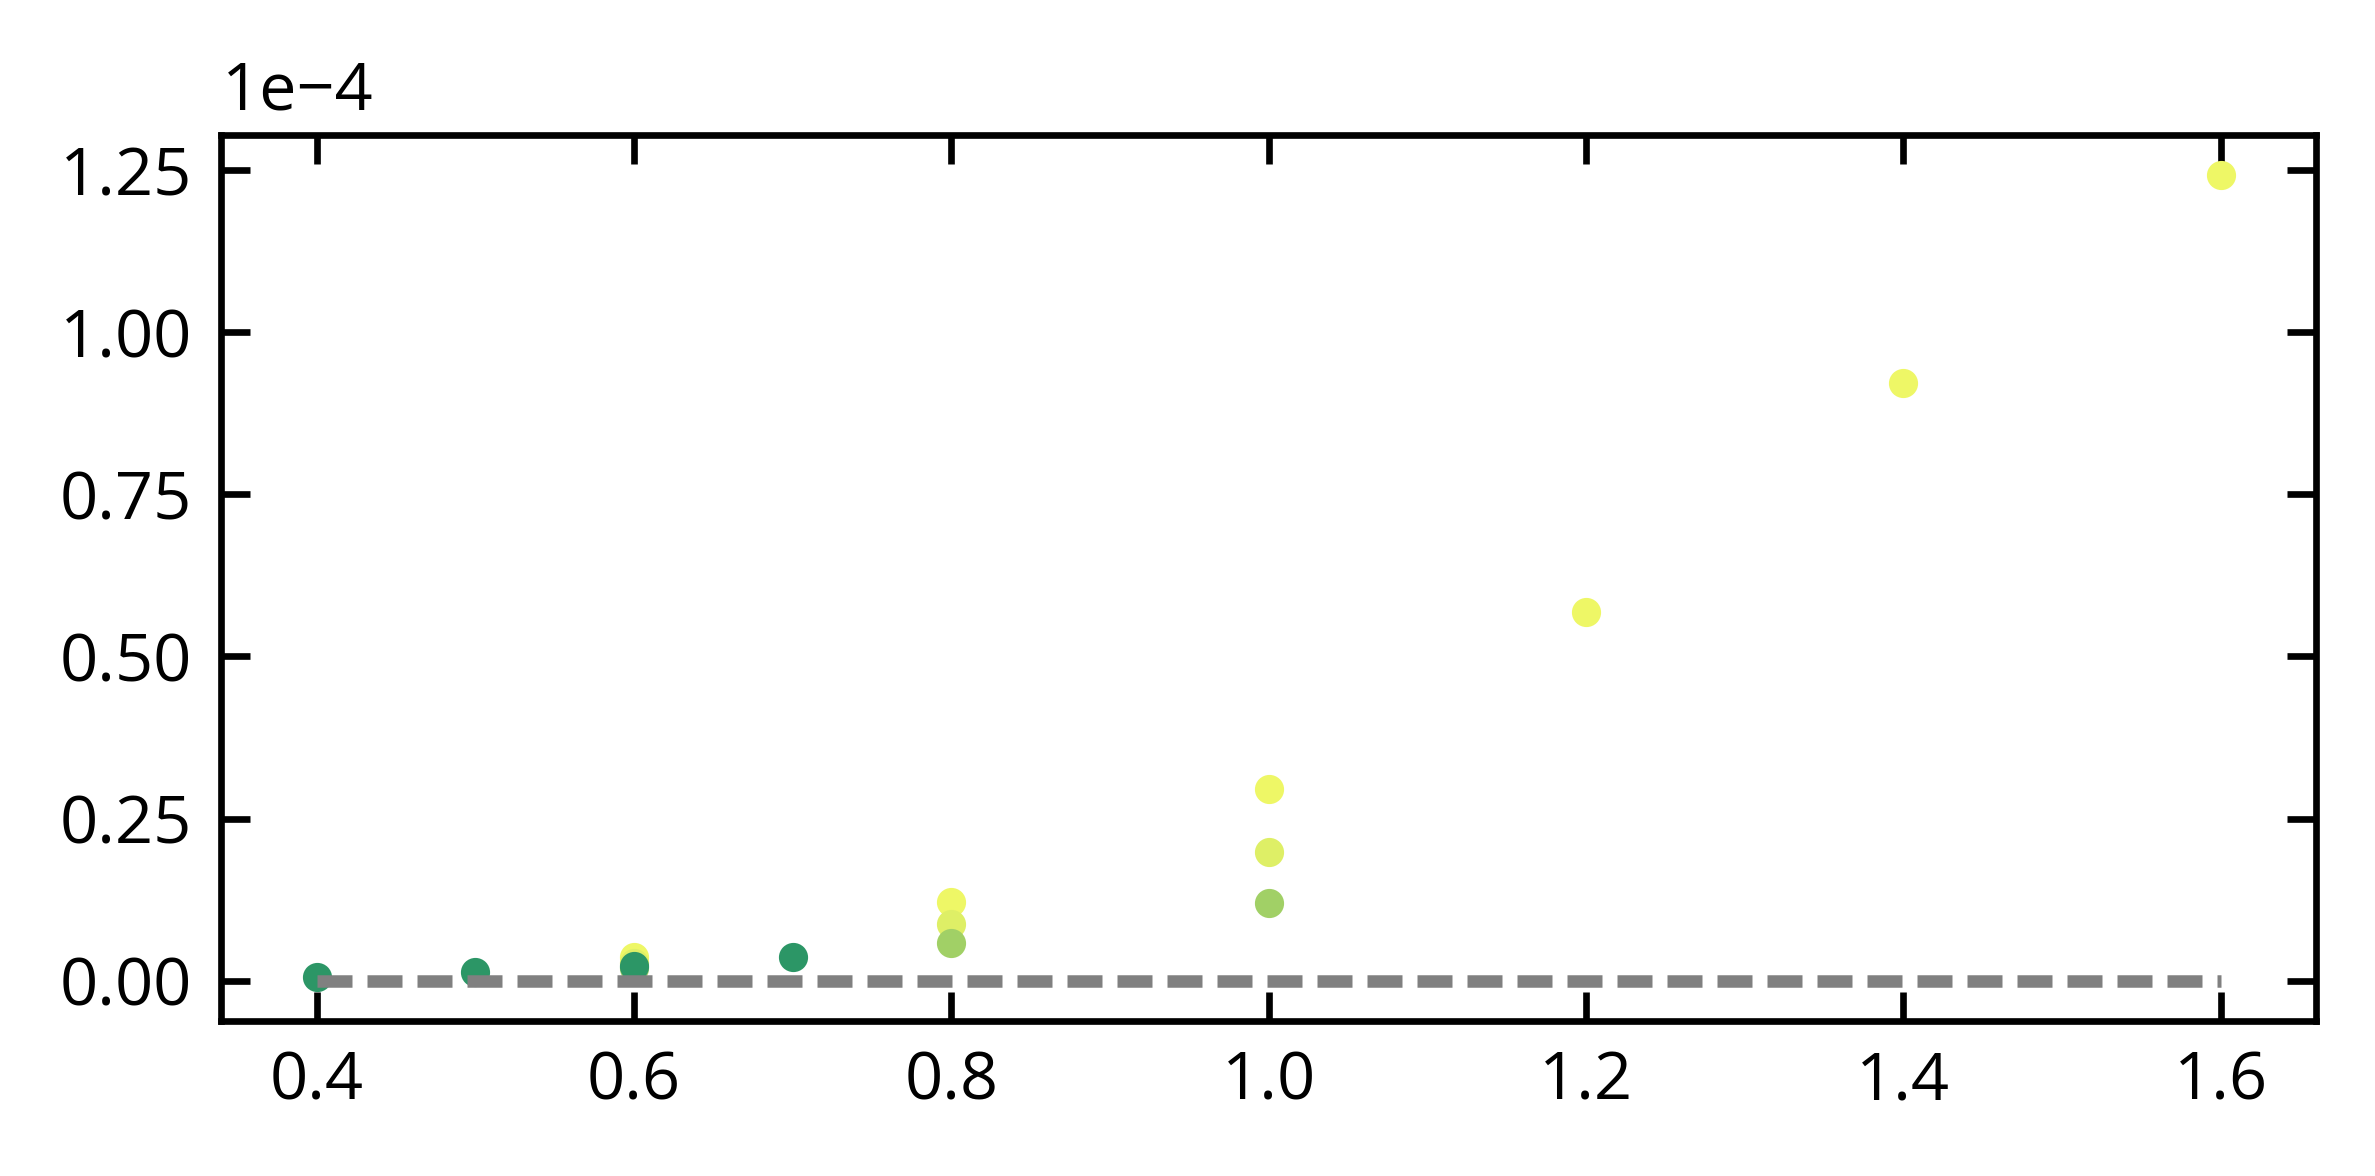

In [319]:
'''Plot the ensemble drift growth rate'''
fig = plt.figure(figsize=[4,2])
for case in case_ensemble:
    plt.plot(case.ustar,case.da,'.',color=plt.cm.get_cmap('summer')(1-case.Bo/4))
ustar_ = np.arange(0.4,1.6,0.01)
plt.plot(ustar_,np.zeros(ustar_.shape),'--',color='gray')

In [355]:
case = case_Bo[3]
eta1,eta2,spectrum1,spectrum2 = case.spectrum_filtering(N_time = 96, N_padding = 9, WINDOW = True)

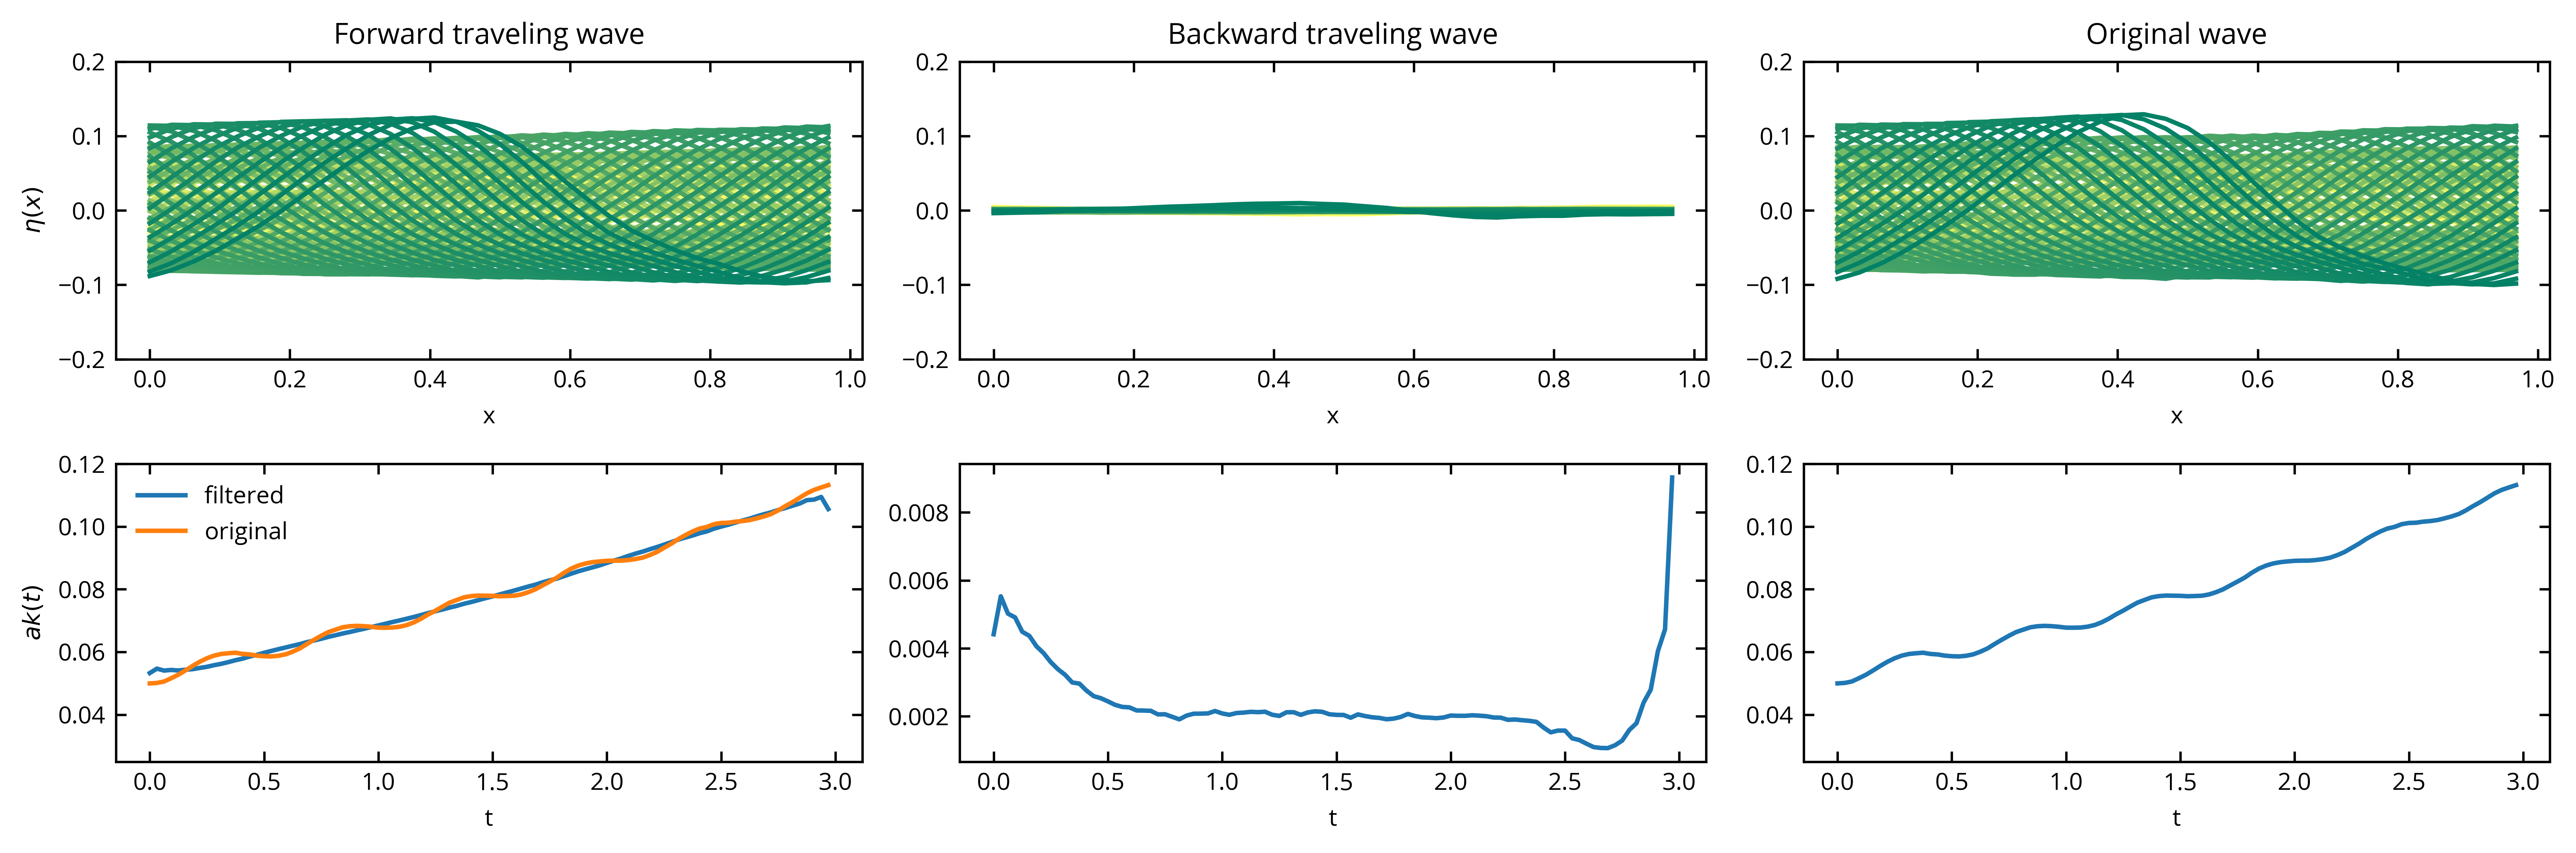

In [356]:
'''Plot the forward travelling and backward travelling wave''' 
plt.style.use('pof')
N_zero = 9
N_time = 96
from matplotlib import gridspec
fig = plt.figure(figsize=(12,4)) 
gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1]) 
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[0,2])
ax6 = plt.subplot(gs[1,2])
eta_std1 = np.zeros(N_time)
eta_std2 = np.zeros(N_time)
eta_std3 = np.zeros(N_time)
# x = np.arange(0,32)/32
x = np.arange(0,32)/32
t = np.arange(0,N_time)/32
for i in range(0,N_time):
    ax1.plot(x,np.real(eta1[i+N_zero])*2*np.pi,color=plt.cm.get_cmap('summer')(1-i/N_time))
    ax2.plot(x,np.real(eta2[i+N_zero])*2*np.pi,color=plt.cm.get_cmap('summer')(1-i/N_time))
    ax5.plot(x,np.real(eta1[i+N_zero]+eta2[i+N_zero])*2*np.pi,color=plt.cm.get_cmap('summer')(1-i/N_time))
    eta_std1[i] = np.std(eta1[i+N_zero])*2*np.pi*2**0.5
    eta_std2[i] = np.std(eta2[i+N_zero])*2*np.pi*2**0.5
    eta_std3[i] = np.std(case.eta_unfiltered[i])*2*np.pi*2**0.5
ax3.plot(t,eta_std1,label='filtered'); ax3.plot(t,eta_std3,label='original'); ax4.plot(t,eta_std2), ax6.plot(t,eta_std3)
ax1.set_ylim(-0.2,0.2); ax2.set_ylim(-0.2,0.2); ax5.set_ylim(-0.2,0.2);
ax3.set_ylim(0.025,0.12); ax6.set_ylim(0.025,0.12)
ax1.set_ylabel(r"$\eta(x)$"); ax1.set_xlabel("x"); ax2.set_xlabel("x"); ax5.set_xlabel("x");
ax3.set_ylabel(r"$ak(t)$"); ax3.set_xlabel("t"); ax4.set_xlabel("t"); ax6.set_xlabel("t");
ax1.set_title('Forward traveling wave');ax2.set_title('Backward traveling wave');ax5.set_title('Original wave')
ax3.legend(loc='upper left'); fig.tight_layout(); 

In [ ]:
'''Plotting u_partition'''
from mpl_toolkits.axes_grid1 import ImageGrid
def plot_partition(u_group, eta, t, L0 = 1, N = 512):
    x = np.linspace(-L0/2, L0/2, N, endpoint = False) + L0/N/2
    x_eta = np.linspace(-L0/2, L0/2, np.size(eta), endpoint = False) + L0/np.size(eta)/2
    eta_interp = np.interp(x, x_eta, eta)
    fig = plt.figure(figsize=(2,5))
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(3,1),
                     axes_pad=0.05,
                     share_all=True,
                     cbar_location="bottom",
                     cbar_mode="single",
                     cbar_size="7%",
                     cbar_pad=0.05,
                     )
    for (ax, u) in zip(grid, ugroup):
        pcontour = ax.imshow(np.rot90(u), vmax = 0.05, vmin = -0.05, extent = (-L0/2,L0/2,-L0/2,L0/2), cmap='RdBu')
        ax.set_axis_off()
        ax.plot(x, eta_interp, color='k', linewidth=1)
    # The viscous scaling of shear layer thickness
    Re = 5000; nu = 1/Re; T = 1.475; c = 0.6778; USTAR_RATIO = 1.2
    ustar = USTAR_RATIO*c
    # ax.plot(ampl._eta_data.x, ampl._eta_data.eta - (nu*T*t)**0.5, color='r', linewidth=1)
    # ax.plot(ampl._eta_data.x, ampl._eta_data.eta - nu*1/ustar, color='g', linewidth=1)
    ax.cax.colorbar(pcontour)
    grid[0].set_title("t = %gT" %t)

ugroup = case.call_partition(95)
plot_partition(ugroup, case.eta_filtered[95], 3)

In [450]:
from energy_func import energy_process
filename = working_dir + 'rerun/linear_wavewind_nowind_Ustar0ak0.05Bo1.47Re10660.LEVEL11/'+'budgetWaterwind.dat'
filename = working_dir + 'rerun/linear_wavewind_nowind_Ustar0ak0.05Bo0.53Re5000.LEVEL11/'+'budgetWaterwind.dat'
filename = working_dir + 'rerun/linear_wavewind_nowind_Ustar0ak0.05Bo3.31Re20000.LEVEL11/'+'budgetWaterwind.dat'
# filename = working_dir + 'rerun/linear_rerun_Ustar1ak0.05Bo1.47Re10660.LEVEL11/'+'budgetWaterwind.dat'
filename = working_dir + 'rerun/linear_wavewind_nowind_dirac_Ustar0ak0.05Bo0.27Re2990.LEVEL11/'+'budgetWaterwind.dat'
# filename = working_dir + 'rerun/linear_wavewind_nowind_dirac_Ustar0ak0.05Bo0.53Re5000.LEVEL11/'+'budgetWaterwind.dat'
# filename = working_dir + 'rerun/linear_wavewind_nowind_dirac_Ustar0ak0.05Bo1.47Re10660.LEVEL11/'+'budgetWaterwind.dat'
filename = working_dir + 'rerun/linear_wavewind_nowind_dirac_Ustar0ak0.05Bo3.31Re20000.LEVEL11/'+'budgetWaterwind.dat'
filename = working_dir + 'rerun/linear_wavewind_nowind_2_Ustar0ak0.05Bo1.47Re10660.LEVEL12/'+'budgetWaterwind.dat'
# filename = working_dir + 'rerun/linear_wavewind_rerun_Ustar1ak0.05Bo1.47Re10660.LEVEL11/'+'budgetWaterwind.dat'
energy, total, total_diss, growth_rate, growth_rate_diss, total_hat, total_diss_hat = energy_process (filename)

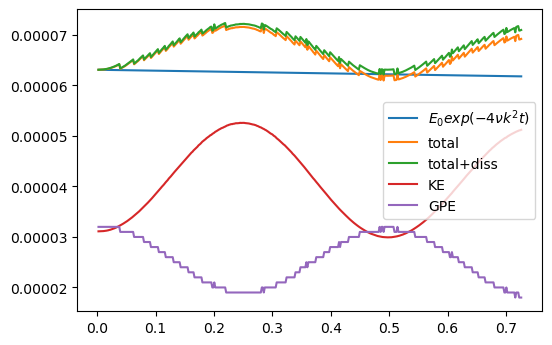

In [460]:
T = 1.93375 # Bo=1.47
# T = 2.19667 # Bo=3.31
nu = 1/10600.
plt.plot(energy.t/T, (total[0]+0.875)*np.exp(-4*energy.t*nu*(2*np.pi)**2), label = r'$E_0 exp(-4\nu k^2 t)$')
plt.plot(energy.t/T, total+0.875, label='total')
plt.plot(energy.t/T, total_diss+0.875, label='total+diss')
plt.plot(energy.t/T, energy.ke, label='KE')
plt.plot(energy.t/T, energy.gpe+0.875, label='GPE')
plt.legend()

In [22]:
# Dissipation

512

In [ ]:
''' Animation '''
from matplotlib import animation
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

plt.rcParams['figure.dpi'] = 100

# Single animation generation function
def plot_animation(frame_number = 31, interval_time = 100):

    # First set up the figure, the axis, and the plot element we want to animate   
    global path,N,L0,Bo,Re
    fig = plt.figure(figsize=(10,4))
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(1,3),
                     axes_pad=0.15,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="7%",
                     cbar_pad=0.15,
                     )
    t = 0
    ugroup = u_partition(path, t, Bo = Bo, L0=1, N=512)
    ampl = interface(path, L0, t)
    for (ax, u) in zip(grid, ugroup):
        pcontour = ax.imshow(np.rot90(u), vmax = 0.05, vmin = -0.05, extent=(-L0/2,L0/2,-L0/2,L0/2), cmap='RdBu')
        ax.set_axis_off()
        ax.plot(ampl._eta_data.x, ampl._eta_data.eta, color='k', linewidth=1)
    ax.cax.colorbar(pcontour)
    fig.suptitle("t = %g" %t, size=16)

    # animation function.  This is called sequentially
    def animate(i):
        global path
        t = i/16
        ugroup = u_partition(path, t, Bo = Bo, L0=1, N=512)
        ampl = interface(path, Npoint = 128, L0=L0, time=t)
        fig.suptitle("t = %g" %t, size=16)
        for (ax, u) in zip(grid, ugroup):
            ax.clear()
            pcontour = ax.imshow(np.rot90(u), vmax = 0.05, vmin = -0.05, extent=(-L0/2,L0/2,-L0/2,L0/2), cmap='RdBu')
            ax.set_axis_off()
            ax.plot(ampl._eta_data.x, ampl._eta_data.eta, color='k', linewidth=1)
        # The viscous scaling of shear layer thickness
        nu = 1/Re; T = 1.15
        ax.plot(ampl._eta_data.x, ampl._eta_data.eta - (nu*T*t)**0.5, color='r', linewidth=1)
    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, frames=frame_number, interval=interval_time, blit = False)  
    return anim

working_dir = '/home/jiarong/research/projects/windwave/'
path = working_dir + 'linear_m5B0Ustar1.2ak0.05Bo0.53Re5000.LEVEL11'
path = working_dir + 'linear_m5B0Ustar0.6ak0.05Bo3.31Re20000.LEVEL11'
path = working_dir + 'linear_m5B0Ustar0.9ak0.05Bo1.47Re10600.LEVEL11'
path = working_dir + 'rerun/linear_rerun_Ustar1ak0.05Bo1.47Re10660.LEVEL11'
path = working_dir + 'rerun/linear_wavewind_nowind_dirac_Ustar0ak0.05Bo3.31Re20000.LEVEL11/'
# path = working_dir + 'linear_m5B0Ustar0.8ak0.05Bo1.47Re10600.LEVEL11'
# [0.7, 0.05, 0.27, 2990., 11]
L0 = 1; N = 512; Bo = 0.53; Re = 2990
L0 = 1; N = 512; Bo = 3.31; Re = 20000
# L0 = 1; N = 512; Bo = 1.47; Re = 10600
anim = plot_animation(frame_number = 12, interval_time = 400) # Specify frame number
HTML(anim.to_html5_video())

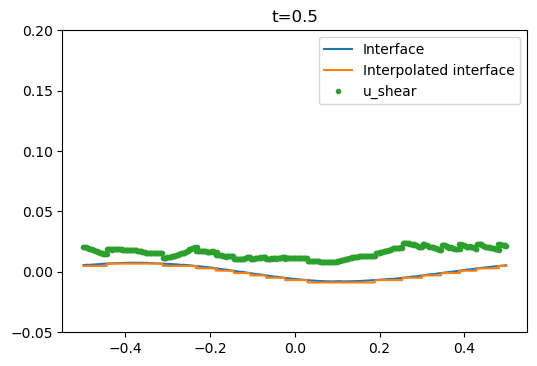

In [246]:
# Wave coordinate
path = working_dir + 'linear_m5B0Ustar0.8ak0.05Bo1.47Re10600.LEVEL11'
path = working_dir + 'linear_m5B0Ustar0.6ak0.05Bo3.31Re20000.LEVEL11'
path = working_dir + 'linear_m5B0Ustar0.8ak0.05Bo1.47Re10600.LEVEL11'
t = 0.5
u_air, u_water, omega_air, omega_water = fields(path,t)
u,f,omega = fields_original(path,t)
ampl = interface(path, L0, t) 
ak = np.std(ampl.eta_interp)*2*np.pi
# Hilbert transformation to get the phase
analytic_signal = hilbert(ampl.eta_interp)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# Construct mesh
x = np.linspace(-L0/2,L0/2,N,endpoint = False) + L0/N/2
phase = np.interp(x, ampl.x_interp, instantaneous_phase)
z = np.linspace(-L0/2,L0/2,N,endpoint = False) + L0/N/2
z_tile, phase_tile = np.meshgrid(z,phase)
# Linear wave velocity field; a bunch of parameters are specified
k_ = 2*np.pi; h_ = L0/2; g_ = 1; rho_ = 1
ak_ = 0.05 # Use instantaneous ak?
Bo = 1.47
sigma_ = 1/(Bo*k_**2)
c_ = (g_/k_+sigma_*k_/rho_)**0.5
ux = ak_*c_*np.cos(phase_tile)*np.exp(k_*z_tile)
ux_irrot = ux*f
u_shear = u_water-ux_irrot
ugroup = (u_water, ux_irrot, u_shear)

# Theoretical distribution of shear us_a
eta = np.interp(x, ampl.x_interp, ampl.eta_interp)
us_a = ak_*c_*np.cos(phase)*np.exp(k_*eta)
q0 = 0.1*c_*0.8
q = c_ - us_a - ((c_-us_a)**2-q0*(2*c_-q0))**0.5
# 1D Interpolate where x coordinate is matching but z need to be found
us_s = np.zeros(x.size)
z_s = np.zeros(x.size)
for i in range(0,512):
    j = np.searchsorted(z, eta[i], side="right")
    us_s[i] = u_shear[i][j-2]
    z_s[i] = z[j-1]
plt.plot(x,eta, label = 'Interface')
plt.plot(x,z_s, label = 'Interpolated interface')
plt.plot(x,us_s, '.', label = 'u_shear')
# plt.plot(x,z_s)
# plt.plot(x,q)
plt.ylim([-0.05,0.2])
plt.title('t=%g' %t)
plt.legend()

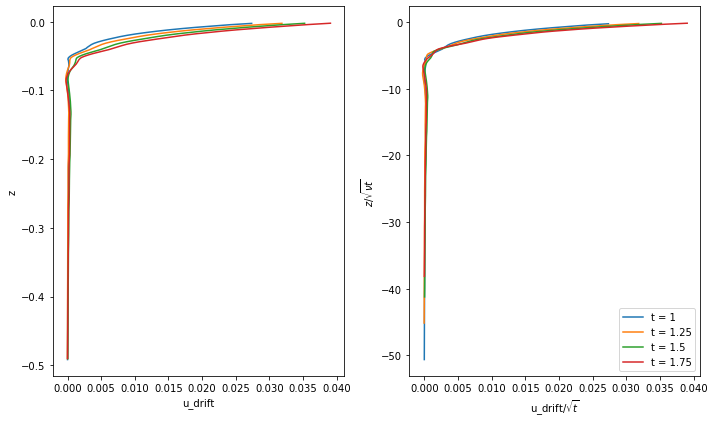

In [166]:
def water_profile(t,ax1,ax2,commonpath,L0,nu,ustar):
    # Read in the fields
    u_air, u_water, omega_air, omega_water = fields(path, t)
    # Average profile (wave coordinate!)
    u_water_1D_nointerp = np.average(u_water, axis=0)
    u_water_interp = np.zeros(u_water.shape)
    ampl = interface(path, Npoint=512, L0=1, time=t)
    zmax = L0/2 - ampl.eta_interp.max(); zmin = -L0/2 - ampl.eta_interp.min()
    zgrid = np.linspace(zmin, zmax, 512)
    from scipy.interpolate import interp1d
    for i in range(u_water.shape[0]):
        z = np.linspace(-L0/2,L0/2,512) - ampl.eta_interp[i]
        f = interp1d(z, u_water[i,:])
        ugrid = f(zgrid)
        u_water_interp[i] = ugrid
    u_water_1D = np.average(u_water_interp, axis=0)
    ax1.plot(u_water_1D[0:255], zgrid[0:255]/L0, label = 't = %g' %t)
    ax2.plot(u_water_1D[0:255], zgrid[0:255]/L0/(nu*t)**0.5, label = 't = %g' %t)
#     ax1.plot(u_water_1D_nointerp, z/L0, label = 'original coord')
#     ax1.spines['right'].set_visible(False)
#     ax1.spines['top'].set_visible(False)
#     ax1.set_ylabel(r'$(z-\eta)/\lambda$',fontsize=14); ax1.set_xlabel(r'$\overline{U}(z)$',fontsize=14)
#     ax1.set_ylim([-0.5,0.5])
#     ax1.set_xlim([-0.01,0.09])
#     ax1.legend(loc='lower right')
    return u_water, u_water_interp, u_water_1D
    
# Example
working_dir = '/home/jiarong/research/projects/windwave/'
path = working_dir + 'linear_m5B0Ustar1ak0.05Bo1.47Re10660.LEVEL11'
fig = plt.figure(figsize=(10, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
# for i in range (1,7):
#     t = i/4
#     u_water, u_water_interp = water_profile(t,ax1,ax2,path,L0=1,nu=1/10600,ustar=1)
path = working_dir + 'linear_m5B0Ustar0.8ak0.05Bo1.47Re10600.LEVEL11'
N_time = 8
t = np.zeros(N_time)
drift = np.zeros(N_time)
for i in range (4,N_time):
    t[i] = i/4
    u_water, u_water_interp, u_water_1D = water_profile(t[i],ax1,ax2,path,L0=1,nu=1/10600,ustar=0.8)
    drift[i] = u_water_1D[255]
ax1.set_ylabel('z')
ax2.set_ylabel(r'$z/\sqrt{\nu t}$')
ax1.set_xlabel('u_drift')
ax2.set_xlabel(r'u_drift/$\sqrt{t}$')
plt.legend()
fig.tight_layout()

In [106]:
case_ensemble = []
for ustar in [0.6,0.8,1.0]:
    for Bo,Re in zip([0.27,0.53,1.47],[2990,5000,10660]):
        case = Case(ustar=ustar, ak=0.05, Bo=Bo, Re=Re, LEVEL=11, L0=1., g=1., k=2.*np.pi,
             working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_')
        case.drift_evolution()
        case_ensemble.append(case)

Given k = 6.28319 (1/m), calculated omega = 5.43638 (1/s), period = 1.15577 (s), phase speed c = 0.865227 (m/s), wavelength = 1 (m), Bo = 0.269669
Given k = 6.28319 (1/m), calculated omega = 4.2589 (1/s), period = 1.47531 (s), phase speed c = 0.677825 (m/s), wavelength = 1 (m), Bo = 0.529351
Given k = 6.28319 (1/m), calculated omega = 3.24922 (1/s), period = 1.93375 (s), phase speed c = 0.51713 (m/s), wavelength = 1 (m), Bo = 1.4682
Given k = 6.28319 (1/m), calculated omega = 5.43638 (1/s), period = 1.15577 (s), phase speed c = 0.865227 (m/s), wavelength = 1 (m), Bo = 0.269669
Given k = 6.28319 (1/m), calculated omega = 4.2589 (1/s), period = 1.47531 (s), phase speed c = 0.677825 (m/s), wavelength = 1 (m), Bo = 0.529351
Given k = 6.28319 (1/m), calculated omega = 3.24922 (1/s), period = 1.93375 (s), phase speed c = 0.51713 (m/s), wavelength = 1 (m), Bo = 1.4682
Given k = 6.28319 (1/m), calculated omega = 5.43638 (1/s), period = 1.15577 (s), phase speed c = 0.865227 (m/s), wavelength = 

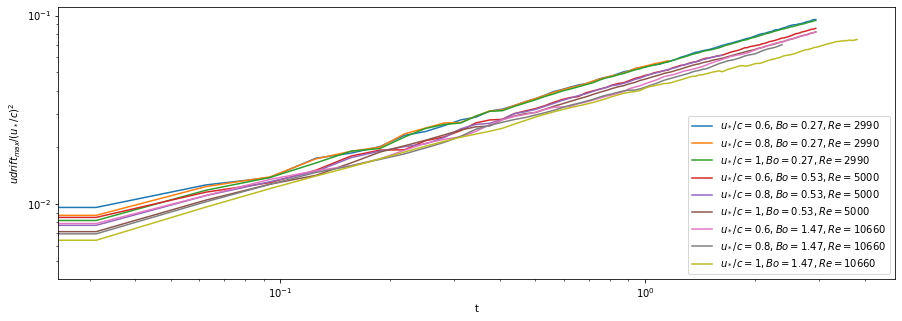

In [144]:
fig = plt.figure(figsize=[15,5])
for i in [0,3,6]:
    case = case_ensemble[i]
    plt.plot(case.t,case.drift_max/(case.ustar)**2, label = r'$u_*/c=%g,Bo=%g,Re=%g$' %(case.ustar,case.Bo,case.Re))
for i in [1,4,7]:
    case = case_ensemble[i]
    plt.plot(case.t,case.drift_max/(case.ustar)**2, label = r'$u_*/c=%g,Bo=%g,Re=%g$' %(case.ustar,case.Bo,case.Re))
for i in [2,5,8]:
    case = case_ensemble[i]
    plt.plot(case.t,case.drift_max/(case.ustar)**2, label = r'$u_*/c=%g,Bo=%g,Re=%g$' %(case.ustar,case.Bo,case.Re))
plt.legend(loc='lower right')
plt.ylabel(r'$udrift_{max}/(u_*/c)^2$'); plt.xlabel(r't')
plt.xscale('log')
plt.yscale('log')

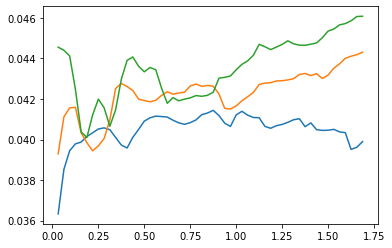

In [69]:
# plt.plot(case1.t[1:],case1.drift_max[1:])
plt.plot(case2.t[1:],case2.drift_max[1:]/(case2.t[1:]**0.5)/case2.ustar**2)
# plt.plot(case3.t[1:],case3.drift_max[1:])
plt.plot(case4.t[1:],case4.drift_max[1:]/(case4.t[1:]**0.5)/case4.ustar**2)
plt.plot(case5.t[1:],case5.drift_max[1:]/(case5.t[1:]**0.5)/case5.ustar**2)

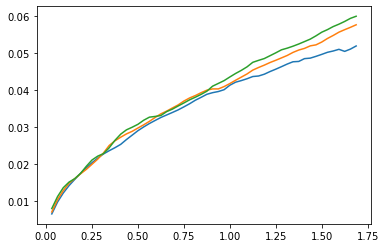

In [75]:
plt.plot(case2.t[1:],case2.drift_max[1:]/case2.ustar**2)
# plt.plot(case3.t[1:],case3.drift_max[1:])
plt.plot(case4.t[1:],case4.drift_max[1:]/case4.ustar**2)
plt.plot(case5.t[1:],case5.drift_max[1:]/case5.ustar**2)
# plt.plot(case5.t[1:],case5.t[1:]**0.5)

In [ ]:
# First perform time FFT (following Dauxois)
# path = working_dir + 'rerun/linear_wavewind_nowind_dirac_Ustar0ak0.05Bo3.31Re20000.LEVEL11/'
# path = working_dir + 'rerun/linear_wavewind_rerun_Ustar1ak0.05Bo1.47Re10660.LEVEL11/'
# N_time = 96
# N_point = 32
# eta_series = []
# t = np.zeros(N_time)
# for i in range (0,N_time):
#     t[i] = i/32.
#     ampl = interface(path, Npoint=N_point, L0=1, time=t[i])
#     eta_series.append(ampl.eta_interp-np.average(ampl.eta_interp))
# eta_series = np.array(eta_series)
# eta_complex = np.zeros(eta_series.shape)
# eta_complex = eta_complex.astype(complex)
# for i in range(0,N_point):
#     f_omega = np.fft.fft(eta_series[:,i]-np.average(eta_series[:,i]))
#     f_omega_positive = np.zeros(f_omega.shape)
#     f_omega_positive = f_omega_positive.astype(complex)
#     f_omega_positive[0:np.int(N_time/2)] = np.copy(f_omega[0:np.int(N_time/2)])*2
#     eta_complex[:,i] = np.fft.ifft(f_omega_positive)
# eta1 = np.zeros(eta_series.shape)
# eta2 = np.zeros(eta_series.shape)
# eta_real = np.zeros(eta_series.shape)
# for i in range(0,N_time):
#     f_kx = np.fft.fft(eta_complex[i,:])
#     f_kx_positive = np.zeros(f_kx.shape)
#     f_kx_positive = f_kx_positive.astype(complex)
#     f_kx_positive[0:np.int(N_point/2)] = np.copy(f_kx[0:np.int(N_point/2)])
#     f_kx_negative = f_kx-f_kx_positive
#     eta1[i,:] = np.real(np.fft.ifft(f_kx_negative))
#     eta2[i,:] = np.real(np.fft.ifft(f_kx_positive))
#     eta_real = eta1[i,:]+eta2[i,:]